In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten
from tensorflow.keras.regularizers import l2

In [2]:
data = pd.read_csv('../raw_data/merged_data.csv')
data

,text,is_fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0
38654,"LexisNexis, a provider of legal, regulatory an...",0
38655,In the shadow of disused Soviet-era factories ...,0
38656,Vatican Secretary of State Cardinal Pietro Par...,0


In [3]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [4]:
%%time

data['text_clean'] = data['text'].apply(cleaning)
data

CPU times: user 1min 54s, sys: 2.57 s, total: 1min 56s
Wall time: 1min 57s


,text,is_fake,text_clean
0,Donald Trump just couldn t wish all Americans ...,1,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",1,friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",1,christmas day donald trump announce would back...
4,Pope Francis used his annual Christmas Day mes...,1,pope francis use annual christmas day message ...
...,...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0,nato ally tuesday welcome president donald tru...
38654,"LexisNexis, a provider of legal, regulatory an...",0,lexisnexis provider legal regulatory business ...
38655,In the shadow of disused Soviet-era factories ...,0,shadow disused sovietera factories minsk stree...
38656,Vatican Secretary of State Cardinal Pietro Par...,0,vatican secretary state cardinal pietro paroli...


In [5]:
X = data.text_clean
y = data.is_fake

In [6]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
%%time
# max_words = 10000  
# max_sequence_length = 500  

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

CPU times: user 6.58 s, sys: 62.7 ms, total: 6.65 s
Wall time: 6.67 s


In [40]:
len(word_index)

156905

In [8]:
# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [15]:
sequences = tokenizer.texts_to_sequences(data.text_clean)

lengths_of_texts =  [len(text) for text in sequences]

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_sequences, maxlen=avg_length_text, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_sequences, maxlen=avg_length_text, padding='pre')
X_test_pad = pad_sequences(X_test_sequences, maxlen=avg_length_text, padding='post', truncating='post')

---

## SimpleRNN Model

In [105]:
%%time
from keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 30, 
             input_length=avg_length_text), ## recall that we set the post-padding length to be this value 
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER 
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics 
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=1000, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/1000
846/846 [==============================] - 79s 88ms/step - loss: 0.5912 - accuracy: 0.6534 - val_loss: 0.5090 - val_accuracy: 0.7760
Epoch 2/1000
846/846 [==============================] - 74s 87ms/step - loss: 0.3111 - accuracy: 0.9084 - val_loss: 0.1594 - val_accuracy: 0.9578
Epoch 3/1000
846/846 [==============================] - 73s 86ms/step - loss: 0.1893 - accuracy: 0.9565 - val_loss: 0.1515 - val_accuracy: 0.9517
Epoch 4/1000
846/846 [==============================] - 72s 85ms/step - loss: 0.1743 - accuracy: 0.9593 - val_loss: 0.2947 - val_accuracy: 0.9033
Epoch 5/1000
846/846 [==============================] - 73s 87ms/step - loss: 0.1450 - accuracy: 0.9687 - val_loss: 0.1266 - val_accuracy: 0.9598
Epoch 6/1000
846/846 [==============================] - 73s 86ms/step - loss: 0.1414 - accuracy: 0.9697 - val_loss: 0.1696 - val_accuracy: 0.9441
Epoch 7/1000
846/846 [==============================] - 73s 86ms/step - loss: 0.1189 - accuracy: 0.9759 - val_loss: 0.1306 -

In [106]:
# Evaluate the model on the test set
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)

182/182 [==============================] - 3s 18ms/step - loss: 0.1294 - accuracy: 0.9684


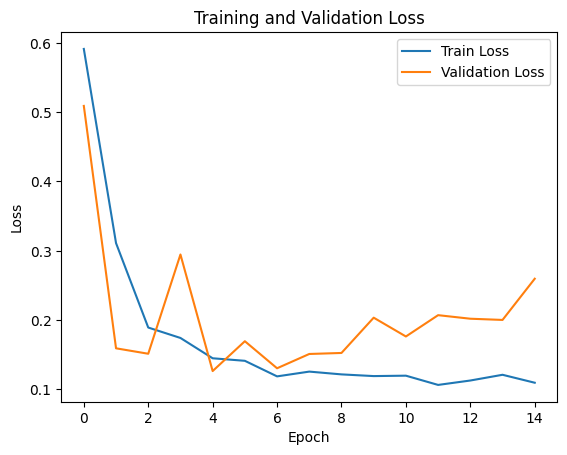

In [107]:
# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

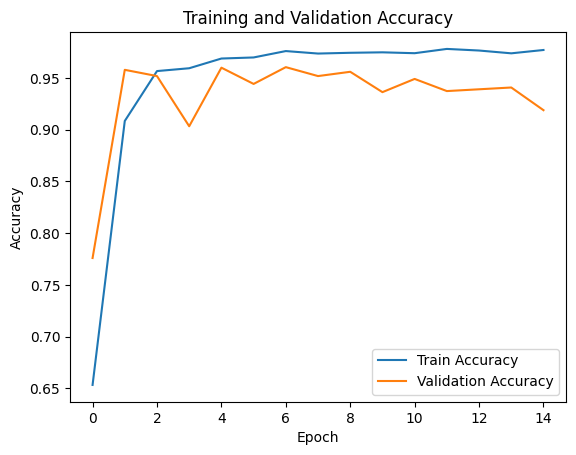

In [108]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [109]:
y_pred = model_rnn.predict(X_test_pad)

182/182 [==============================] - 4s 18ms/step


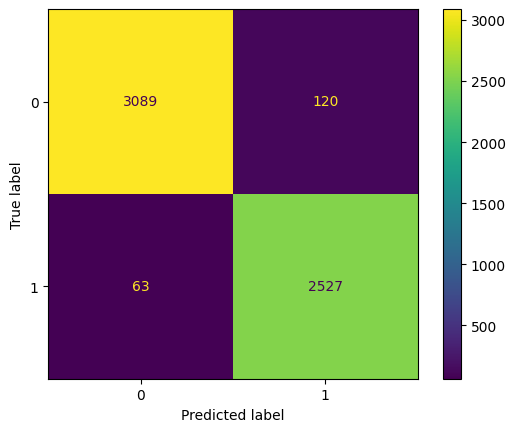

In [110]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf

predicted = tf.squeeze(y_pred)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

---

## Basic NN Model

In [23]:
# model_3 = Sequential([
#     Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
#     Flatten(),
#     Dense(8, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
#     Dropout(0.5),  # Adding dropout
#     Dense(1, activation='sigmoid')
# ])

# model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ## Decrease patience, allow restore to best weights during patience
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history_3 = model_3.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_val_pad, y_test), callbacks=[early_stopping])

Epoch 1/50
136/136 [==============================] - 2s 10ms/step - loss: 0.5857 - accuracy: 0.7430 - val_loss: 1.0234 - val_accuracy: 0.5104
Epoch 2/50
136/136 [==============================] - 1s 8ms/step - loss: 0.2613 - accuracy: 0.9271 - val_loss: 1.3605 - val_accuracy: 0.5047
Epoch 3/50
136/136 [==============================] - 1s 8ms/step - loss: 0.1964 - accuracy: 0.9585 - val_loss: 1.5870 - val_accuracy: 0.4994
Epoch 4/50
136/136 [==============================] - 1s 8ms/step - loss: 0.1635 - accuracy: 0.9663 - val_loss: 1.7259 - val_accuracy: 0.5020
Epoch 5/50
136/136 [==============================] - 1s 8ms/step - loss: 0.1444 - accuracy: 0.9703 - val_loss: 1.8620 - val_accuracy: 0.4970
Epoch 6/50
136/136 [==============================] - 1s 8ms/step - loss: 0.1289 - accuracy: 0.9744 - val_loss: 2.0294 - val_accuracy: 0.4954


In [24]:
# final_train_loss_3 = history_3.history['loss'][-1]
# final_train_accuracy_3 = history_3.history['accuracy'][-1]

# final_val_loss_3 = history_3.history['val_loss'][-1]
# final_val_accuracy_3 = history_3.history['val_accuracy'][-1]

# print("Final Training Loss:", final_train_loss_3)
# print("Final Training Accuracy:", final_train_accuracy_3)
# print("Final Validation Loss:", final_val_loss_3)
# print("Final Validation Accuracy:", final_val_accuracy_3)


Final Training Loss: 0.12894344329833984
Final Training Accuracy: 0.9743902683258057
Final Validation Loss: 2.029386520385742
Final Validation Accuracy: 0.49543026089668274


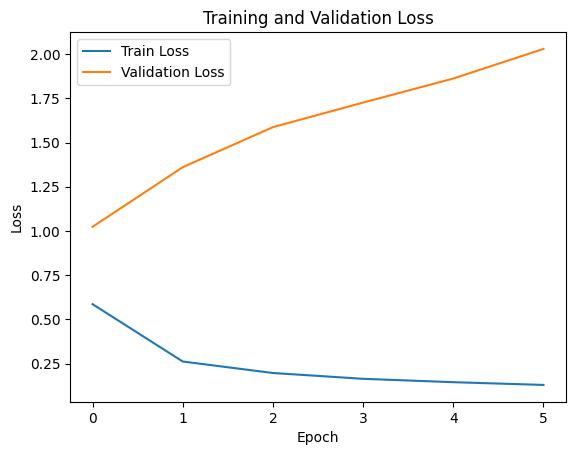

In [25]:
# # Plot the training and validation loss
# plt.plot(history_3.history['loss'], label='Train Loss')
# plt.plot(history_3.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

---

## New Texts on Both Models

In [26]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""


In [27]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday 
that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being 
honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [33]:
# import spacy
# from spacy.lang.en import English
# from nltk.corpus import stopwords
# import nltk
# import time

# ## download the dictionary for stopwords
# nltk.download('stopwords')

# ## get the set of stopwords 
# stop_words_set = set(stopwords.words('english'))

# ## Load English tokenizer from spacy
# nlp = English()
# spacy_tokenizer = nlp.tokenizer ## make instance 

# ## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
# def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
#     result = []
    
#     # Tokenize using spaCy's tokenizer
#     for text in texts:
#         tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
#         result.append(" ".join(tokens))
    
#     return result

[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# bbc_cleaned = optimized_preprocess([bbc_snippet])
# theonion_cleaned = optimized_preprocess([theonion_snippet])


In [111]:
bbc_cleaned = cleaning(bbc_snippet)
theonion_cleaned = cleaning(theonion_snippet)

In [112]:
bbc_cleaned

'uk face another five years high interest rat stem rise price influential global group warn international monetary fund expect uk highest inflation slowest growth next year g economy include us france germany canada italy japan however treasury say recent revisions uk growth factor imfs report outlook draw weekend developments israel forecast never perfect give many factor affect economic growth geopolitics weather report point right direction especially align forecast imf international organisation member countries say forecast make growth follow year advance economies often within percentage point actually happen july last year forecast uk economy would grow revise upwards start year official uk figure release last month estimate countrys economy actually expand accord imfs latest forecast produce every six months expect uk grow quickly germany keep uk bottom place growth among g downgrade uks prospect growth next year estimate economy grow make slowest grow develop country widely pr

In [114]:
bbc_seq = tokenizer.texts_to_sequences(bbc_cleaned)
theonion_seq = tokenizer.texts_to_sequences(theonion_cleaned)


In [115]:
bbc_pad = pad_sequences(bbc_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')
theonion_pad = pad_sequences(theonion_seq, maxlen=  avg_length_text, padding = 'post', truncating = 'post')

In [119]:
bbc_pad.shape

(1026, 214)

In [120]:
bbc_pad[0]

array([4024,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [116]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))

33/33 [==============================] - 1s 16ms/step
[[0.0165698 ]
 [0.9584936 ]
 [0.01656971]
 ...
 [0.0165697 ]
 [0.01656971]
 [0.95878744]]
20/20 [==============================] - 0s 19ms/step
[[0.01656971]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.0165697 ]
 [0.95878744]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.9584936 ]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.95878744]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.0165697 ]
 [0.01656971]
 [0.9584936 ]
 [0.01656971]
 [0.95878744]
 [0.0165697 ]
 [0.01656971]
 [0.01656973]
 [0.01656971]
 [0.01656971]
 [0.0165697 ]
 [0.0165697 ]
 [0.01656971]
 [0.01656971]
 [0.01656971]
 [0.0165697 ]
 [0.0165697 ]
 [0.0165697 ]
 [0.01656971]
 [0.95878744]
 [0.0165697 ]
 [0.95873046]
 [0.01656971]
 [0.95878744]
 [0.01656971]
 [0.0165697 ]
 [0.

In [121]:
bbc_pred = model_rnn.predict(bbc_pad)

33/33 [==============================] - 1s 33ms/step


In [122]:
round(bbc_pred.mean())

0

In [123]:
bbc_pred

array([[0.0165698 ],
       [0.9584936 ],
       [0.01656971],
       ...,
       [0.0165697 ],
       [0.01656971],
       [0.95878744]], dtype=float32)

In [118]:
model_rnn.predict(theonion_pad)

20/20 [==============================] - 0s 18ms/step


array([[0.01656971],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.0165697 ],
       [0.95878744],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.9584936 ],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.95878744],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.0165697 ],
       [0.01656971],
       [0.9584936 ],
       [0.01656971],
       [0.95878744],
       [0.0165697 ],
       [0.01656971],
       [0.01656973],
       [0.01656971],
       [0.01656971],
       [0.0165697 ],
       [0.0165697 ],
       [0.01656971],
       [0.01656971],
       [0.01656971],
       [0.0165697 ],
       [0.016

---

In [86]:
horse = "Facing a financial dilemma after breaking his leg, a local horse who didn’t have health insurance was reportedly unable to afford being shot in the head, sources confirmed Tuesday. “Unfortunately, I don’t have the money for basic treatment for my injuries,” said Scout, explaining that he used to be on a PPO through his horse-racing job but had been without insurance since getting laid off. “America’s healthcare system is in a sad state when horses like me can’t get access to being shot right between the eyes. The gun they would use to shoot me costs $5,000 alone. I might have to live out the rest of my life in a hospice stable.” At press time, Scout had posted a GoFundMe to help him raise money to get a hole blasted through his skull."


In [87]:
horse_cleaned = optimized_preprocess([horse])
horse_seq = tokenizer.texts_to_sequences(horse_cleaned)
horse_pad = pad_sequences(horse_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')

In [88]:
model_rnn.predict(horse_pad)

1/1 [==============================] - 0s 55ms/step


array([[0.96092135]], dtype=float32)

---

In [89]:
abortion = """A Texas judge has granted permission to a woman whose foetus has a fatal abnormality to have an abortion, despite the state's ban on the procedure.
The ruling - which Texas may challenge - is thought to be one of the first attempts to seek a court-ordered abortion.
Texas law prohibits abortion except to save the life of the pregnant woman.
Abortion advocates claim the exception is too vague and puts women at risk.
That is the argument of Kate Cox, a 31-year-old mother of two from the Dallas area, who is currently 20 weeks pregnant.
Her foetus has been diagnosed with trisomy 18, a lethal condition that, in almost all cases, results in miscarriage, stillbirth or the death of the baby within the first year of life.
According to her lawsuit, Ms Cox's physicians told her their "hands are tied" as long as the baby had a heartbeat, because of the state abortion ban.
Doctors have told her continuing with the pregnancy poses a risk to her health and, potentially, her ability to carry another child. Ms Cox has already had to visit the emergency room four times because of pain and discharge, her lawyers said.
"Kate Cox needs an abortion, and she needs it now," her petition reads.
On Thursday, Travis County District Judge Maya Guerra Gamble granted that request, handing down a temporary restraining order allowing Ms Cox to terminate her pregnancy, and protecting her doctor from civil and criminal penalties if she performs the procedure.
"The idea that Ms Cox wants desperately to be a parent, and this law might actually cause her to lose that ability, is shocking and would be a genuine miscarriage of justice," Judge Gamble, a Democrat, said.
Lawyers for the state may ask a higher court to block the order.
At the hearing, Jonathan Stone, with the Texas Attorney General's office, argued that Ms Cox "does not meet all of the elements" to qualify for a medical exception.
A ruling in Ms Cox's case could compel the state to define more clearly when abortions are allowed under the existing law.
The emergency appeal comes as the Texas Supreme Court weighs another effort to clarify the state's abortion ban. That one is led by the Center for Reproductive Rights, which is also representing Ms Cox.
Molly Duane, a lawyer for the Center, told the conservative court late last month that the near-total ban had left physicians "terrified" to use their medical judgment over fear of harsh penalties.
Doctors who perform abortions in Texas could risk life in prison, loss of their medical license and hundreds of thousands of dollars in fines.
While there are medical exceptions to the Texas ban, "no one knows what it means and the state won't tell us", Ms Duane said.
A lawyer for the attorney general, Beth Klusmann, said existing standards allowed doctors to use "reasonable" medical judgment.
That case - Zurawski v State of Texas - could be decided by the state's highest civil court in the coming weeks.
After the Supreme Court overturned Roe v Wade in June 2022 - effectively rescinding a nationwide right to an abortion - decisions about the procedure have been left to individual states."""


In [90]:
abortion_cleaned = optimized_preprocess([abortion])
abortion_seq = tokenizer.texts_to_sequences(abortion_cleaned)
abortion_pad = pad_sequences(abortion_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')

In [92]:
model_rnn.predict(abortion_pad)

1/1 [==============================] - 0s 79ms/step


array([[0.97170377]], dtype=float32)

---

In [94]:
alarm = """US lawmakers have voted to formally reprimand New York Democrat Jamaal Bowman for pulling a fire alarm while congress was in session.

The Republican-led House of Representatives passed the resolution with 214 votes for and 191 against.
The alarm went off and triggered an evacuation as Democrats were trying to stall a vote to avert a government shutdown in September.
Mr Bowman had said he activated the alarm by mistake while rushing to vote.
The resolution to censure Mr Bowman was introduced by Republican House representative Lisa McClain from Michigan on Tuesday.
Ms McClain accused Mr Bowman of "working nefariously to prevent a vote" when he set off the alarm, during which lawmakers were working on passing a government spending bill to avert a shutdown.
"It is reprehensible that a Member of Congress would go to such lengths to prevent House Republicans from bringing forth a vote to keep the government operating and Americans receiving their paychecks," Ms McClain said in a statement.
The congressman was caught on video pulling the fire alarm in the Cannon House Office Building on 30 September. He denied it was on purpose.
"Today, as I was rushing to make a vote, I came to a door that is usually open for votes but today would not open.
"I am embarrassed to admit that I activated the fire alarm, mistakenly thinking it would open the door. I regret this and sincerely apologize for any confusion this caused," he said in a statement.
"I want to be very clear, this was not me, in any way trying to delay any vote," the left-wing Democrat from the Bronx added.
A censure acts as a formal vote of deep disapproval of a Congress member's conduct. It does not act as an expulsion and does not prevent them from carrying out their duties as lawmakers.
In October, Mr Bowman was also charged by Washington prosecutors for falsely triggering the alarm and he pleaded guilty to a misdemeanour charge.
He also agreed to pay the maximum $1,000 fine.
Pulling a fire alarm when there is no emergency is a criminal offence punishable by fines and prison time in Washington."""

In [95]:
alarm_cleaned = optimized_preprocess([alarm])
alarm_seq = tokenizer.texts_to_sequences(alarm_cleaned)
alarm_pad = pad_sequences(alarm_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')

In [96]:
model_rnn.predict(alarm_pad)

1/1 [==============================] - 0s 48ms/step


array([[0.01890147]], dtype=float32)

---

In [98]:
model_rnn.save('model_rnn.h5')